# **8. Benchmark de modelos preentrenados para clasificación**
---
## **8.1 Introducción**
---

En este trabajo comparamos cuatro modelos preentrenados populares (entrenados con *ImageNet*s): **ResNet18** (nuestro baseline), **EfficientNet** (**B0** y **B3**), **MobileNet_V3_Large** y **ConvNeXt_Tiny**.

En el caso del **ResNet18** baseline, descongelamos únicamente la última capa del backbone para que pueda ajustarse durante el entrenamiento. En los otros tres modelos, el fine-tune se realiza desde **bloques anteriores**, lo que implica un mayor número de capas entrenables. En resumen, para esta primera parte del trabajo, entrenamos de la siguiente forma:

- ResNet18: desde fc (132.099 parámetros entrenables)  
- EfficientNet-B0: desde features.8 (740.867 parámetros entrenables)  
- MobileNet V3 Large: desde features.8 (3.125.539 parámetros entrenables)  
- ConvNeXt Tiny: desde features.7 (14.487.043 parámetros entrenables)

Luego, reemplazamos ese bloque/capa descongelado/a por una identidad (`nn.Identity()`), lo que permite conectar un clasificador personalizado compuesto por capas lineales, activaciones y dropout que realiza la clasificación final.

En resumen, el flujo es:

**backbone (bloque/capa descongelados/a entrenables) → capa identidad → clasificador personalizado**.

Este método aprovecha el aprendizaje transferido del backbone mientras ajusta la salida para nuestras clases específicas.

Para la optimización, consideramos tres valores diferentes de learning rate como principal hiperparámetro a ajustar, dado que los recursos y tiempo disponibles limitan la exploración de otros ajustes.

----------------

La elección de estas arquitecturas se basa en el trabajo *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks* ([Paper en arXiv](https://arxiv.org/pdf/1905.11946)), así como en el análisis presentado en este [artículo](https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/). En particular, se seleccionó el modelo **EfficientNet_B0** (utilizado como baseline en dicho estudio) por mostrar un desempeño superior al **ResNet32**, como se ilustra en la siguiente figura (Figura 1 del paper).

Además, se incorporaron los modelos **MobileNet_V3_Large** y **ConvNeXt_Tiny** para ampliar la comparación. MobileNet_V3 también presenta buen desempeño usando *compound scaling* (método desarrollado para balancear profundidad, ancho y resolución de la red de manera eficiente), mientras que ConvNeXt_Tiny es una arquitectura moderna, eficiente y competitiva que no aparece en el estudio original.

Dado el método desarrollado en el estudio de EfficientNet y basado en la mejora de performance lograda mediante *compound scaling* (ver el paper para más detalles), en etapas posteriores se planea extender el análisis a modelos **EfficientNet** más avanzados, como los **B1**, **B3**, y sucesivos.


<img src="https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png" alt="Descripción" height="400">

## **8.2 Entrenamiento de los modelos**
---

Configuración preliminar.

In [69]:
# Recomendado por PyTorch Lightning para aprovechar Tensor Cores (por la arquitectura de mi GPU)
import torch
torch.set_float32_matmul_precision('medium')

import shutil

# Borrar checkpoints anteriores
shutil.rmtree("checkpoints", ignore_errors=True)

# Borrar logs anteriores
shutil.rmtree("lightning_logs", ignore_errors=True)

Cargo tensores, creo datasets y creo los dataloaders.

In [70]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar los tensores guardados
X_train, y_train = torch.load("train_normalizado.pt")
X_val, y_val = torch.load("val_normalizado.pt")
X_test, y_test = torch.load("test_normalizado.pt")

# Crear datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Crear loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)

Defino funciones principales para entrenar modelos.

In [71]:
import torch
import torch.nn as nn
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from torchvision import models
import os
from lightning.pytorch.callbacks import EarlyStopping

def get_in_features(base_model):
    base_model.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(next(base_model.parameters()).device)
        out = base_model(dummy)
    return out.shape[1]

class LitClassifier(LightningModule):
    def __init__(self, base_model_fn, weights, freeze_layer_name, num_classes=3, lr=3e-5):
        super().__init__()
        self.save_hyperparameters()
        self.training_outputs = []
        self.validation_outputs = []

        base_model = base_model_fn(weights=weights)
        unfreeze = False
        for name, param in base_model.named_parameters():
            if freeze_layer_name in name:
                unfreeze = True
            param.requires_grad = unfreeze

        if hasattr(base_model, "fc"):
            base_model.fc = nn.Identity()
            in_features = get_in_features(base_model)
        elif hasattr(base_model, "classifier"):
            base_model.classifier = nn.Identity()
            in_features = get_in_features(base_model)

        self.model = nn.Sequential(
            base_model,
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.training_outputs.append(loss.detach())
        return loss  

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.training_outputs).mean()
        self.log("train_loss", avg_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.training_outputs.clear()

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.validation_outputs.append({"val_loss": loss.detach(), "val_acc": acc.detach()})
        return None  

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x["val_loss"] for x in self.validation_outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in self.validation_outputs]).mean()
        self.log("val_loss", avg_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", avg_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.validation_outputs.clear()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


def train_and_test_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "fc"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.8"),
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.8"),
        (models.convnext_tiny, models.ConvNeXt_Tiny_Weights.DEFAULT, "features.7"),
    ]

    learning_rates = [1e-4, 3e-5, 1e-5]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            name = fn.__name__
            print(f"Entrenando {name} con lr={lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=30,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

In [72]:
# Descomentar para ejecutar el entrenamiento
results, history = train_and_test_models(train_loader, val_loader, test_loader)

Entrenando resnet18 con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 27/27 [00:09<00:00,  2.84it/s, v_num=0, val_loss=1.070, val_acc=0.446]

Metric val_loss improved. New best score: 1.073


Epoch 1: 100%|██████████| 27/27 [00:09<00:00,  2.79it/s, v_num=0, val_loss=1.030, val_acc=0.487, train_loss=1.090]

Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 1.034


Epoch 2: 100%|██████████| 27/27 [00:09<00:00,  2.83it/s, v_num=0, val_loss=0.997, val_acc=0.516, train_loss=1.000]

Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 0.997


Epoch 4: 100%|██████████| 27/27 [00:09<00:00,  2.83it/s, v_num=0, val_loss=0.959, val_acc=0.525, train_loss=0.922]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.959


Epoch 5: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s, v_num=0, val_loss=0.937, val_acc=0.505, train_loss=0.891]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.937


Epoch 6: 100%|██████████| 27/27 [00:09<00:00,  2.81it/s, v_num=0, val_loss=0.901, val_acc=0.561, train_loss=0.866]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.901


Epoch 11: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s, v_num=0, val_loss=0.897, val_acc=0.528, train_loss=0.819]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.897


Epoch 14: 100%|██████████| 27/27 [00:09<00:00,  2.78it/s, v_num=0, val_loss=0.887, val_acc=0.575, train_loss=0.844]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.887


Epoch 15: 100%|██████████| 27/27 [00:09<00:00,  2.74it/s, v_num=0, val_loss=0.860, val_acc=0.598, train_loss=0.832]

Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.860


Epoch 17: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s, v_num=0, val_loss=0.846, val_acc=0.599, train_loss=0.805]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.846


Epoch 20: 100%|██████████| 27/27 [00:09<00:00,  2.77it/s, v_num=0, val_loss=0.837, val_acc=0.613, train_loss=0.809]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.837


Epoch 25: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s, v_num=0, val_loss=0.857, val_acc=0.584, train_loss=0.811]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.837. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s, v_num=0, val_loss=0.857, val_acc=0.584, train_loss=0.811]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Entrenando efficientnet_b0 con lr=0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
740 K     Trainable params
3.6 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=1.010, val_acc=0.521]

Metric val_loss improved. New best score: 1.007


Epoch 1: 100%|██████████| 27/27 [00:14<00:00,  1.84it/s, v_num=0, val_loss=0.943, val_acc=0.534, train_loss=1.010]

Metric val_loss improved by 0.065 >= min_delta = 0.001. New best score: 0.943


Epoch 2: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.900, val_acc=0.580, train_loss=0.874]

Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.900


Epoch 3: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.868, val_acc=0.579, train_loss=0.778]

Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.868


Epoch 4: 100%|██████████| 27/27 [00:14<00:00,  1.83it/s, v_num=0, val_loss=0.822, val_acc=0.618, train_loss=0.736]

Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 0.822


Epoch 5: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.815, val_acc=0.620, train_loss=0.724]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.815


Epoch 6: 100%|██████████| 27/27 [00:15<00:00,  1.76it/s, v_num=0, val_loss=0.787, val_acc=0.645, train_loss=0.691]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.787


Epoch 8: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.770, val_acc=0.646, train_loss=0.665]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.770


Epoch 11: 100%|██████████| 27/27 [00:15<00:00,  1.77it/s, v_num=0, val_loss=0.744, val_acc=0.675, train_loss=0.608]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.744


Epoch 12: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.737, val_acc=0.688, train_loss=0.600]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.737


Epoch 14: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.703, val_acc=0.705, train_loss=0.596]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.703


Epoch 15: 100%|██████████| 27/27 [00:15<00:00,  1.76it/s, v_num=0, val_loss=0.699, val_acc=0.702, train_loss=0.574]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.699


Epoch 17: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.695, val_acc=0.705, train_loss=0.554]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.695


Epoch 18: 100%|██████████| 27/27 [00:16<00:00,  1.66it/s, v_num=0, val_loss=0.675, val_acc=0.719, train_loss=0.545]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.675


Epoch 19: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s, v_num=0, val_loss=0.647, val_acc=0.733, train_loss=0.541]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.647


Epoch 20: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s, v_num=0, val_loss=0.626, val_acc=0.754, train_loss=0.533]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.626


Epoch 25: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s, v_num=0, val_loss=0.655, val_acc=0.742, train_loss=0.507]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.626. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 27/27 [00:16<00:00,  1.65it/s, v_num=0, val_loss=0.655, val_acc=0.742, train_loss=0.507]
Entrenando mobilenet_v3_large con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
93.2 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:14<00:00,  1.86it/s, v_num=0, val_loss=0.733, val_acc=0.672]

Metric val_loss improved. New best score: 0.733


Epoch 3: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.731, val_acc=0.680, train_loss=0.725]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.731


Epoch 5: 100%|██████████| 27/27 [00:14<00:00,  1.86it/s, v_num=0, val_loss=0.694, val_acc=0.707, train_loss=0.649]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.694


Epoch 6: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.673, val_acc=0.732, train_loss=0.566]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.673


Epoch 9: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.641, val_acc=0.759, train_loss=0.464]

Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.641


Epoch 11: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.588, val_acc=0.772, train_loss=0.466]

Metric val_loss improved by 0.053 >= min_delta = 0.001. New best score: 0.588


Epoch 14: 100%|██████████| 27/27 [00:14<00:00,  1.85it/s, v_num=0, val_loss=0.580, val_acc=0.801, train_loss=0.434]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.580


Epoch 19: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.789, val_acc=0.811, train_loss=0.181]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.580. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.789, val_acc=0.811, train_loss=0.181]
Entrenando convnext_tiny con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
14.5 M    Trainable params
13.5 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, v_num=0, val_loss=0.965, val_acc=0.549]

Metric val_loss improved. New best score: 0.965


Epoch 1: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s, v_num=0, val_loss=0.744, val_acc=0.676, train_loss=1.020]

Metric val_loss improved by 0.221 >= min_delta = 0.001. New best score: 0.744


Epoch 6: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s, v_num=0, val_loss=0.706, val_acc=0.762, train_loss=0.508]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.706


Epoch 11: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s, v_num=0, val_loss=0.993, val_acc=0.766, train_loss=0.167]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.706. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s, v_num=0, val_loss=0.993, val_acc=0.766, train_loss=0.167]
Entrenando resnet18 con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:09<00:00,  2.89it/s, v_num=0, val_loss=1.130, val_acc=0.284]

Metric val_loss improved. New best score: 1.127


Epoch 1: 100%|██████████| 27/27 [00:10<00:00,  2.63it/s, v_num=0, val_loss=1.110, val_acc=0.332, train_loss=1.120]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 1.112


Epoch 2: 100%|██████████| 27/27 [00:09<00:00,  2.75it/s, v_num=0, val_loss=1.090, val_acc=0.378, train_loss=1.070]

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 1.093


Epoch 3: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s, v_num=0, val_loss=1.090, val_acc=0.389, train_loss=1.060]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.091


Epoch 4: 100%|██████████| 27/27 [00:09<00:00,  2.73it/s, v_num=0, val_loss=1.080, val_acc=0.407, train_loss=1.030]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 1.076


Epoch 5: 100%|██████████| 27/27 [00:09<00:00,  2.77it/s, v_num=0, val_loss=1.060, val_acc=0.402, train_loss=1.020]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.063


Epoch 7: 100%|██████████| 27/27 [00:10<00:00,  2.58it/s, v_num=0, val_loss=1.050, val_acc=0.419, train_loss=0.987]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 1.046


Epoch 8: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=1.040, val_acc=0.408, train_loss=0.978]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.042


Epoch 9: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=1.020, val_acc=0.448, train_loss=0.980]

Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 1.019


Epoch 11: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=1.010, val_acc=0.452, train_loss=0.926]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.011


Epoch 12: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s, v_num=0, val_loss=1.010, val_acc=0.474, train_loss=0.939]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.006


Epoch 13: 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, v_num=0, val_loss=1.000, val_acc=0.458, train_loss=0.925]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.003


Epoch 15: 100%|██████████| 27/27 [00:10<00:00,  2.46it/s, v_num=0, val_loss=0.990, val_acc=0.467, train_loss=0.911]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.990


Epoch 16: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s, v_num=0, val_loss=0.981, val_acc=0.486, train_loss=0.928]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.981


Epoch 17: 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, v_num=0, val_loss=0.977, val_acc=0.486, train_loss=0.894]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.977


Epoch 18: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=0.974, val_acc=0.486, train_loss=0.881]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.974


Epoch 20: 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, v_num=0, val_loss=0.960, val_acc=0.479, train_loss=0.902]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.960


Epoch 23: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s, v_num=0, val_loss=0.946, val_acc=0.503, train_loss=0.864]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.946


Epoch 24: 100%|██████████| 27/27 [00:10<00:00,  2.49it/s, v_num=0, val_loss=0.938, val_acc=0.497, train_loss=0.850]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.938


Epoch 25: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s, v_num=0, val_loss=0.932, val_acc=0.507, train_loss=0.895]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.932


Epoch 29: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s, v_num=0, val_loss=0.929, val_acc=0.521, train_loss=0.860]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.929
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:11<00:00,  2.37it/s, v_num=0, val_loss=0.929, val_acc=0.521, train_loss=0.860]
Entrenando efficientnet_b0 con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
740 K     Trainable params
3.6 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:45<00:00,  0.60it/s, v_num=0, val_loss=1.070, val_acc=0.537]

Metric val_loss improved. New best score: 1.068


Epoch 1: 100%|██████████| 27/27 [00:45<00:00,  0.60it/s, v_num=0, val_loss=1.040, val_acc=0.555, train_loss=1.080]

Metric val_loss improved by 0.030 >= min_delta = 0.001. New best score: 1.039


Epoch 2: 100%|██████████| 27/27 [00:45<00:00,  0.60it/s, v_num=0, val_loss=1.010, val_acc=0.546, train_loss=1.020]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 1.011


Epoch 3: 100%|██████████| 27/27 [00:44<00:00,  0.60it/s, v_num=0, val_loss=0.976, val_acc=0.565, train_loss=0.963]

Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 0.976


Epoch 4: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.961, val_acc=0.577, train_loss=0.924]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.961


Epoch 5: 100%|██████████| 27/27 [00:43<00:00,  0.62it/s, v_num=0, val_loss=0.952, val_acc=0.575, train_loss=0.890]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.952


Epoch 6: 100%|██████████| 27/27 [00:43<00:00,  0.62it/s, v_num=0, val_loss=0.930, val_acc=0.588, train_loss=0.850]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.930


Epoch 7: 100%|██████████| 27/27 [00:43<00:00,  0.62it/s, v_num=0, val_loss=0.923, val_acc=0.592, train_loss=0.817]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.923


Epoch 8: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.918, val_acc=0.586, train_loss=0.790]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.918


Epoch 9: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.907, val_acc=0.588, train_loss=0.770]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.907


Epoch 10: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.874, val_acc=0.596, train_loss=0.775]

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 0.874


Epoch 13: 100%|██████████| 27/27 [00:45<00:00,  0.60it/s, v_num=0, val_loss=0.860, val_acc=0.599, train_loss=0.729]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.860


Epoch 14: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.848, val_acc=0.598, train_loss=0.723]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.848


Epoch 15: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.842, val_acc=0.608, train_loss=0.721]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.842


Epoch 16: 100%|██████████| 27/27 [00:45<00:00,  0.60it/s, v_num=0, val_loss=0.837, val_acc=0.624, train_loss=0.704]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.837


Epoch 18: 100%|██████████| 27/27 [00:45<00:00,  0.60it/s, v_num=0, val_loss=0.826, val_acc=0.626, train_loss=0.685]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.826


Epoch 19: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.812, val_acc=0.625, train_loss=0.677]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.812


Epoch 21: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.801, val_acc=0.633, train_loss=0.663]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.801


Epoch 23: 100%|██████████| 27/27 [00:44<00:00,  0.60it/s, v_num=0, val_loss=0.795, val_acc=0.642, train_loss=0.693]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.795


Epoch 24: 100%|██████████| 27/27 [00:45<00:00,  0.60it/s, v_num=0, val_loss=0.792, val_acc=0.652, train_loss=0.647]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.792


Epoch 25: 100%|██████████| 27/27 [00:44<00:00,  0.60it/s, v_num=0, val_loss=0.787, val_acc=0.654, train_loss=0.649]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.787


Epoch 26: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.780, val_acc=0.668, train_loss=0.662]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.780


Epoch 27: 100%|██████████| 27/27 [00:45<00:00,  0.60it/s, v_num=0, val_loss=0.769, val_acc=0.676, train_loss=0.641]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.769


Epoch 28: 100%|██████████| 27/27 [00:45<00:00,  0.59it/s, v_num=0, val_loss=0.766, val_acc=0.666, train_loss=0.646]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.766


Epoch 29: 100%|██████████| 27/27 [00:44<00:00,  0.60it/s, v_num=0, val_loss=0.771, val_acc=0.659, train_loss=0.669]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:44<00:00,  0.60it/s, v_num=0, val_loss=0.771, val_acc=0.659, train_loss=0.669]
Entrenando mobilenet_v3_large con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
93.2 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, v_num=0, val_loss=1.020, val_acc=0.593]

Metric val_loss improved. New best score: 1.020


Epoch 1: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s, v_num=0, val_loss=0.876, val_acc=0.637, train_loss=1.050]

Metric val_loss improved by 0.144 >= min_delta = 0.001. New best score: 0.876


Epoch 2: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, v_num=0, val_loss=0.814, val_acc=0.662, train_loss=0.890]

Metric val_loss improved by 0.062 >= min_delta = 0.001. New best score: 0.814


Epoch 3: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s, v_num=0, val_loss=0.771, val_acc=0.670, train_loss=0.764]

Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.771


Epoch 4: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, v_num=0, val_loss=0.763, val_acc=0.685, train_loss=0.748]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.763


Epoch 5: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, v_num=0, val_loss=0.718, val_acc=0.737, train_loss=0.707]

Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.718


Epoch 6: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s, v_num=0, val_loss=0.707, val_acc=0.717, train_loss=0.674]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.707


Epoch 10: 100%|██████████| 27/27 [00:26<00:00,  1.04it/s, v_num=0, val_loss=0.637, val_acc=0.748, train_loss=0.588]

Metric val_loss improved by 0.070 >= min_delta = 0.001. New best score: 0.637


Epoch 15: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, v_num=0, val_loss=0.703, val_acc=0.706, train_loss=0.493]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.637. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, v_num=0, val_loss=0.703, val_acc=0.706, train_loss=0.493]
Entrenando convnext_tiny con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
14.5 M    Trainable params
13.5 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [02:07<00:00,  0.21it/s, v_num=0, val_loss=1.080, val_acc=0.519]

Metric val_loss improved. New best score: 1.079


Epoch 1: 100%|██████████| 27/27 [02:31<00:00,  0.18it/s, v_num=0, val_loss=1.030, val_acc=0.547, train_loss=1.090]

Metric val_loss improved by 0.050 >= min_delta = 0.001. New best score: 1.029


Epoch 2: 100%|██████████| 27/27 [02:31<00:00,  0.18it/s, v_num=0, val_loss=0.888, val_acc=0.638, train_loss=1.020]

Metric val_loss improved by 0.141 >= min_delta = 0.001. New best score: 0.888


Epoch 3: 100%|██████████| 27/27 [02:31<00:00,  0.18it/s, v_num=0, val_loss=0.762, val_acc=0.716, train_loss=0.857]

Metric val_loss improved by 0.126 >= min_delta = 0.001. New best score: 0.762


Epoch 4: 100%|██████████| 27/27 [02:31<00:00,  0.18it/s, v_num=0, val_loss=0.714, val_acc=0.733, train_loss=0.740]

Metric val_loss improved by 0.048 >= min_delta = 0.001. New best score: 0.714


Epoch 5: 100%|██████████| 27/27 [02:30<00:00,  0.18it/s, v_num=0, val_loss=0.705, val_acc=0.745, train_loss=0.681]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.705


Epoch 8: 100%|██████████| 27/27 [02:30<00:00,  0.18it/s, v_num=0, val_loss=0.637, val_acc=0.763, train_loss=0.594]

Metric val_loss improved by 0.068 >= min_delta = 0.001. New best score: 0.637


Epoch 13: 100%|██████████| 27/27 [02:30<00:00,  0.18it/s, v_num=0, val_loss=0.594, val_acc=0.774, train_loss=0.476]

Metric val_loss improved by 0.044 >= min_delta = 0.001. New best score: 0.594


Epoch 18: 100%|██████████| 27/27 [02:31<00:00,  0.18it/s, v_num=0, val_loss=0.744, val_acc=0.761, train_loss=0.295]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.594. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 27/27 [02:32<00:00,  0.18it/s, v_num=0, val_loss=0.744, val_acc=0.761, train_loss=0.295]
Entrenando resnet18 con lr=1e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:10<00:00,  2.47it/s, v_num=0, val_loss=1.130, val_acc=0.202]

Metric val_loss improved. New best score: 1.134


Epoch 3: 100%|██████████| 27/27 [00:10<00:00,  2.49it/s, v_num=0, val_loss=1.130, val_acc=0.272, train_loss=1.100]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.126


Epoch 5: 100%|██████████| 27/27 [00:10<00:00,  2.49it/s, v_num=0, val_loss=1.120, val_acc=0.301, train_loss=1.080]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.125


Epoch 7: 100%|██████████| 27/27 [00:10<00:00,  2.48it/s, v_num=0, val_loss=1.110, val_acc=0.338, train_loss=1.070]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.114


Epoch 8: 100%|██████████| 27/27 [00:11<00:00,  2.36it/s, v_num=0, val_loss=1.110, val_acc=0.356, train_loss=1.060]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 1.109


Epoch 9: 100%|██████████| 27/27 [00:10<00:00,  2.49it/s, v_num=0, val_loss=1.100, val_acc=0.393, train_loss=1.040]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.101


Epoch 12: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=1.100, val_acc=0.415, train_loss=1.030]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.099


Epoch 13: 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, v_num=0, val_loss=1.100, val_acc=0.415, train_loss=1.040]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.097


Epoch 16: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s, v_num=0, val_loss=1.090, val_acc=0.441, train_loss=1.030]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.093


Epoch 17: 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, v_num=0, val_loss=1.080, val_acc=0.439, train_loss=1.010]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.083


Epoch 22: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=1.090, val_acc=0.430, train_loss=0.983]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.083. Signaling Trainer to stop.


Epoch 22: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s, v_num=0, val_loss=1.090, val_acc=0.430, train_loss=0.983]
Entrenando efficientnet_b0 con lr=1e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
740 K     Trainable params
3.6 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:43<00:00,  0.63it/s, v_num=0, val_loss=1.110, val_acc=0.314]

Metric val_loss improved. New best score: 1.105


Epoch 1: 100%|██████████| 27/27 [00:43<00:00,  0.63it/s, v_num=0, val_loss=1.090, val_acc=0.376, train_loss=1.080]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 1.091


Epoch 2: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=1.080, val_acc=0.404, train_loss=1.070]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.084


Epoch 3: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=1.080, val_acc=0.411, train_loss=1.060]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.077


Epoch 4: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=1.070, val_acc=0.398, train_loss=1.030]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.070


Epoch 5: 100%|██████████| 27/27 [00:43<00:00,  0.62it/s, v_num=0, val_loss=1.060, val_acc=0.415, train_loss=1.020]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.061


Epoch 6: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=1.050, val_acc=0.416, train_loss=1.000]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.051


Epoch 7: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=1.040, val_acc=0.440, train_loss=0.983]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 1.040


Epoch 8: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=1.030, val_acc=0.456, train_loss=0.971]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.031


Epoch 9: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=1.020, val_acc=0.475, train_loss=0.962]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.020


Epoch 10: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=1.010, val_acc=0.479, train_loss=0.937]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.012


Epoch 11: 100%|██████████| 27/27 [00:43<00:00,  0.62it/s, v_num=0, val_loss=1.000, val_acc=0.487, train_loss=0.932]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.003


Epoch 12: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.996, val_acc=0.501, train_loss=0.916]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.996


Epoch 13: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.992, val_acc=0.499, train_loss=0.897]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.992


Epoch 14: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.981, val_acc=0.517, train_loss=0.891]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.981


Epoch 15: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.971, val_acc=0.522, train_loss=0.882]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.971


Epoch 16: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.969, val_acc=0.520, train_loss=0.860]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.969


Epoch 17: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.963, val_acc=0.517, train_loss=0.845]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.963


Epoch 19: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.960, val_acc=0.524, train_loss=0.834]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.960


Epoch 20: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.949, val_acc=0.532, train_loss=0.818]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.949


Epoch 21: 100%|██████████| 27/27 [00:43<00:00,  0.62it/s, v_num=0, val_loss=0.944, val_acc=0.539, train_loss=0.814]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.944


Epoch 22: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.940, val_acc=0.548, train_loss=0.798]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.940


Epoch 23: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.936, val_acc=0.540, train_loss=0.813]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.936


Epoch 24: 100%|██████████| 27/27 [00:43<00:00,  0.62it/s, v_num=0, val_loss=0.934, val_acc=0.543, train_loss=0.796]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.934


Epoch 25: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.931, val_acc=0.549, train_loss=0.816]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.931


Epoch 26: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.921, val_acc=0.552, train_loss=0.777]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.921


Epoch 27: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.917, val_acc=0.547, train_loss=0.792]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.917


Epoch 28: 100%|██████████| 27/27 [00:43<00:00,  0.63it/s, v_num=0, val_loss=0.909, val_acc=0.553, train_loss=0.771]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.909


Epoch 29: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.898, val_acc=0.566, train_loss=0.788]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.898
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:44<00:00,  0.61it/s, v_num=0, val_loss=0.898, val_acc=0.566, train_loss=0.788]
Entrenando mobilenet_v3_large con lr=1e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
93.2 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=1.100, val_acc=0.309]

Metric val_loss improved. New best score: 1.105


Epoch 1: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=1.090, val_acc=0.408, train_loss=1.090]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 1.086


Epoch 2: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=1.050, val_acc=0.394, train_loss=1.040]

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 1.052


Epoch 3: 100%|██████████| 27/27 [00:29<00:00,  0.92it/s, v_num=0, val_loss=1.000, val_acc=0.414, train_loss=0.976]

Metric val_loss improved by 0.049 >= min_delta = 0.001. New best score: 1.003


Epoch 4: 100%|██████████| 27/27 [00:29<00:00,  0.92it/s, v_num=0, val_loss=0.952, val_acc=0.502, train_loss=0.889]

Metric val_loss improved by 0.051 >= min_delta = 0.001. New best score: 0.952


Epoch 5: 100%|██████████| 27/27 [00:29<00:00,  0.92it/s, v_num=0, val_loss=0.903, val_acc=0.520, train_loss=0.840]

Metric val_loss improved by 0.050 >= min_delta = 0.001. New best score: 0.903


Epoch 6: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.879, val_acc=0.551, train_loss=0.778]

Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.879


Epoch 7: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.863, val_acc=0.561, train_loss=0.742]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.863


Epoch 8: 100%|██████████| 27/27 [00:29<00:00,  0.92it/s, v_num=0, val_loss=0.797, val_acc=0.645, train_loss=0.728]

Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.797


Epoch 11: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.794, val_acc=0.637, train_loss=0.702]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.794


Epoch 12: 100%|██████████| 27/27 [00:28<00:00,  0.93it/s, v_num=0, val_loss=0.746, val_acc=0.710, train_loss=0.696]

Metric val_loss improved by 0.049 >= min_delta = 0.001. New best score: 0.746


Epoch 13: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.742, val_acc=0.687, train_loss=0.697]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.742


Epoch 14: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.733, val_acc=0.698, train_loss=0.697]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.733


Epoch 15: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.727, val_acc=0.714, train_loss=0.666]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.727


Epoch 16: 100%|██████████| 27/27 [00:29<00:00,  0.92it/s, v_num=0, val_loss=0.713, val_acc=0.719, train_loss=0.657]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.713


Epoch 17: 100%|██████████| 27/27 [00:29<00:00,  0.92it/s, v_num=0, val_loss=0.707, val_acc=0.717, train_loss=0.645]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.707


Epoch 20: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.687, val_acc=0.713, train_loss=0.622]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.687


Epoch 23: 100%|██████████| 27/27 [00:29<00:00,  0.92it/s, v_num=0, val_loss=0.665, val_acc=0.730, train_loss=0.608]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.665


Epoch 27: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.653, val_acc=0.736, train_loss=0.590]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.653


Epoch 29: 100%|██████████| 27/27 [00:29<00:00,  0.91it/s, v_num=0, val_loss=0.702, val_acc=0.679, train_loss=0.582]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:29<00:00,  0.90it/s, v_num=0, val_loss=0.702, val_acc=0.679, train_loss=0.582]
Entrenando convnext_tiny con lr=1e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
14.5 M    Trainable params
13.5 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [01:43<00:00,  0.26it/s, v_num=0, val_loss=1.100, val_acc=0.298]

Metric val_loss improved. New best score: 1.097


Epoch 1: 100%|██████████| 27/27 [01:42<00:00,  0.26it/s, v_num=0, val_loss=1.090, val_acc=0.414, train_loss=1.090]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.087


Epoch 2: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=1.070, val_acc=0.486, train_loss=1.080]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 1.072


Epoch 3: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=1.050, val_acc=0.485, train_loss=1.060]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 1.049


Epoch 4: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=1.010, val_acc=0.515, train_loss=1.040]

Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 1.009


Epoch 5: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=0.970, val_acc=0.510, train_loss=0.992]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.970


Epoch 6: 100%|██████████| 27/27 [01:40<00:00,  0.27it/s, v_num=0, val_loss=0.915, val_acc=0.557, train_loss=0.928]

Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 0.915


Epoch 7: 100%|██████████| 27/27 [01:40<00:00,  0.27it/s, v_num=0, val_loss=0.877, val_acc=0.545, train_loss=0.852]

Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 0.877


Epoch 8: 100%|██████████| 27/27 [01:40<00:00,  0.27it/s, v_num=0, val_loss=0.814, val_acc=0.617, train_loss=0.779]

Metric val_loss improved by 0.063 >= min_delta = 0.001. New best score: 0.814


Epoch 9: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=0.793, val_acc=0.650, train_loss=0.763]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.793


Epoch 10: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=0.763, val_acc=0.665, train_loss=0.741]

Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.763


Epoch 11: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=0.741, val_acc=0.697, train_loss=0.712]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.741


Epoch 12: 100%|██████████| 27/27 [01:40<00:00,  0.27it/s, v_num=0, val_loss=0.734, val_acc=0.729, train_loss=0.682]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.734


Epoch 13: 100%|██████████| 27/27 [01:40<00:00,  0.27it/s, v_num=0, val_loss=0.731, val_acc=0.703, train_loss=0.687]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.731


Epoch 14: 100%|██████████| 27/27 [01:40<00:00,  0.27it/s, v_num=0, val_loss=0.712, val_acc=0.732, train_loss=0.685]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.712


Epoch 17: 100%|██████████| 27/27 [01:40<00:00,  0.27it/s, v_num=0, val_loss=0.684, val_acc=0.745, train_loss=0.644]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.684


Epoch 19: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=0.680, val_acc=0.741, train_loss=0.606]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.680


Epoch 22: 100%|██████████| 27/27 [01:40<00:00,  0.27it/s, v_num=0, val_loss=0.675, val_acc=0.743, train_loss=0.592]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.675


Epoch 27: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=0.708, val_acc=0.721, train_loss=0.520]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.675. Signaling Trainer to stop.


Epoch 27: 100%|██████████| 27/27 [01:41<00:00,  0.27it/s, v_num=0, val_loss=0.708, val_acc=0.721, train_loss=0.520]


In [73]:
# Descomentar para ejecutar el entrenamiento
#mn_8_results, mn_8_history = train_and_test_models(train_loader, val_loader, test_loader)

In [74]:
# Guardar resultados y métricas
import pickle

torch.save(results, "results.pt")
torch.save(history, "history.pt")
results = torch.load("results.pt")
history = torch.load("history.pt")

#torch.save(mn_8_results, "mn_8_results.pt")
#torch.save(mn_8_history, "mn_8_history.pt")

#mn_8_results = torch.load("mn_8_results.pt")
#mn_8_history = torch.load("mn_8_history.pt")

A continuación se muestran la pérdida (**loss**) en entrenamiento y validación, así como la precisión (**accuracy**), todas en función de las épocas. Estos gráficos muestran que, en general, los modelos generalizan bien y no presentan sobreajuste, ya que el *early stopping* con una paciencia de 5 detiene el entrenamiento cuando empieza a aparecer el patrón típico de aumento de la pérdida de validación acompañado de una disminución sostenida de la pérdida de entrenamiento.

En general, los modelos presentan comportamientos durante el entrenamiento que dependen del *learning rate* utilizado. Por ejemplo, basado en la pérdida de validación, con el *learning rate* más pequeño los modelos ConvNeXt Tiny y MobileNet V3 Large no muestran signos claros de sobreajuste, mientras que con los *learning rates* más grandes, el *early stopping* entra en juego de forma evidente. En el caso del ResNet18, con el *learning rate* más bajo, el entrenamiento se detiene en las primeras épocas debido al *early stopping*. Además, se observa que a medida que se aumenta el *learning rate*, los modelos tienden a mostrar mejoras consistentes en la precisión (**accuracy**).

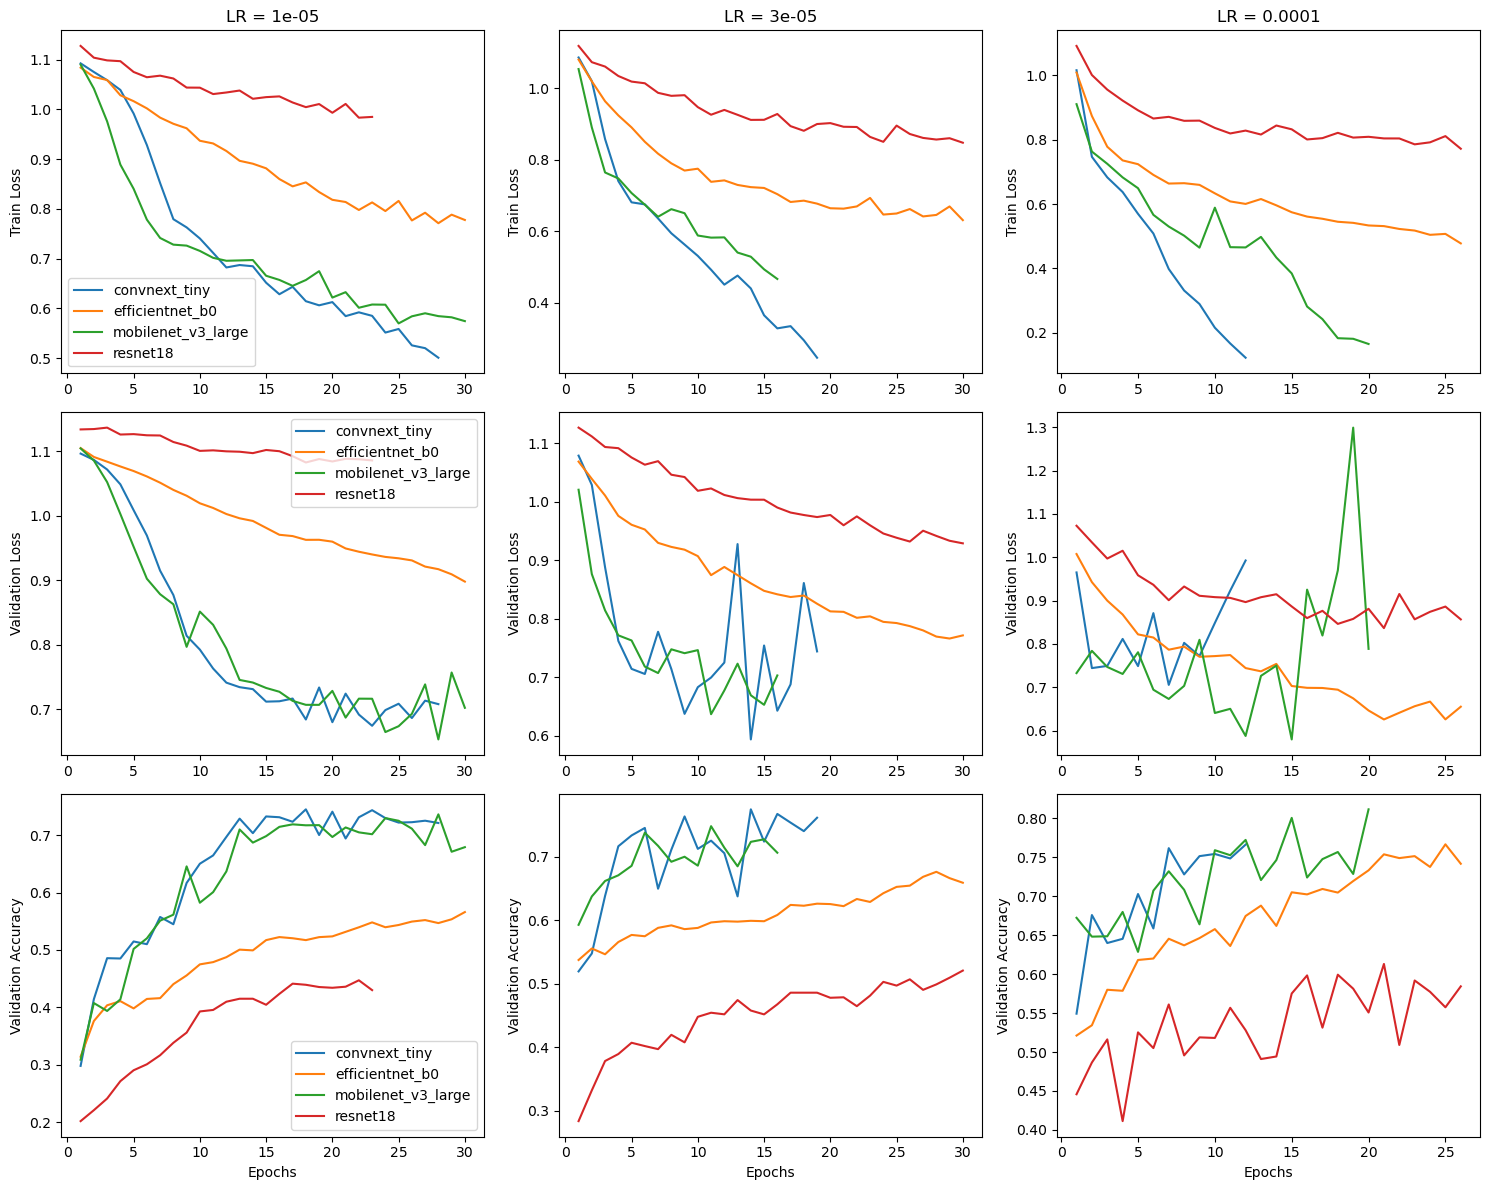

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

history = load_history_from_logs()

lrs = sorted({float(k.split("_lr")[1]) for k in history.keys()})
modelos = sorted({k.split("_lr")[0] for k in history.keys()})

fig, axes = plt.subplots(3, len(lrs), figsize=(5*len(lrs), 12), sharex=False)

for col, lr in enumerate(lrs):
    for modelo in modelos:
        if "feature" in modelo:
            continue

        key = f"{modelo}_lr{lr}"
        if key not in history:
            continue

        df = history[key]

        train_loss_df = df[df['train_loss'].notna()]
        val_df = df[df['val_loss'].notna() & df['val_acc'].notna()]

        if not train_loss_df.empty:
            epochs_train = train_loss_df['epoch'] + 1
            train_loss = train_loss_df['train_loss']
            axes[0, col].plot(epochs_train, train_loss, linestyle='-', label=f"{modelo}")

        if not val_df.empty:
            epochs_val = val_df['epoch'] + 1
            val_loss = val_df['val_loss']
            val_acc = val_df['val_acc']
            axes[1, col].plot(epochs_val, val_loss, linestyle='-', label=f"{modelo}")
            axes[2, col].plot(epochs_val, val_acc, linestyle='-', label=f"{modelo}")

    axes[0, col].set_title(f"LR = {lr}")
    axes[0, col].set_ylabel("Train Loss")
    axes[1, col].set_ylabel("Validation Loss")
    axes[2, col].set_ylabel("Validation Accuracy")
    axes[2, col].set_xlabel("Epochs")

for row in range(3):
    axes[row, 0].legend(loc='best')

plt.tight_layout()
plt.show()

## **8.3 Comparación de modelos con matrices de confusión**
---

A continuación se muestran las matrices de **confusión** para los cuatro modelos, tanto en forma **nominal** como **normalizada**. Se emplea un *learning rate* de $1 \times 10^{-4}$, elegido como valor de referencia para los experimentos. El efecto de este hiperparámetro en el desempeño se analizará más adelante mediante la comparación de métricas como **accuracy**, **recall**, **F1** y un **puntaje personalizado**.

Se puede observar que el modelo MobileNet V3 Large junto con el ConvNeXt Tiny presentan los mejores resultados al predecir muy bien la clase *Normal*, bien la clase *Osteopenia*, y tener un comportamiento aceptable al predecir la clase *Osteoporosis*. El modelo EfficientNet-B0 predice muy bien la clase *Osteopenia*, predice bien la clase *Normal*, pero de forma regular la clase *Osteoporosis*. ResNet18 muestra una excelente predicción de la clase *Osteopenia*, pero desempeños regulares en las otras dos clases.


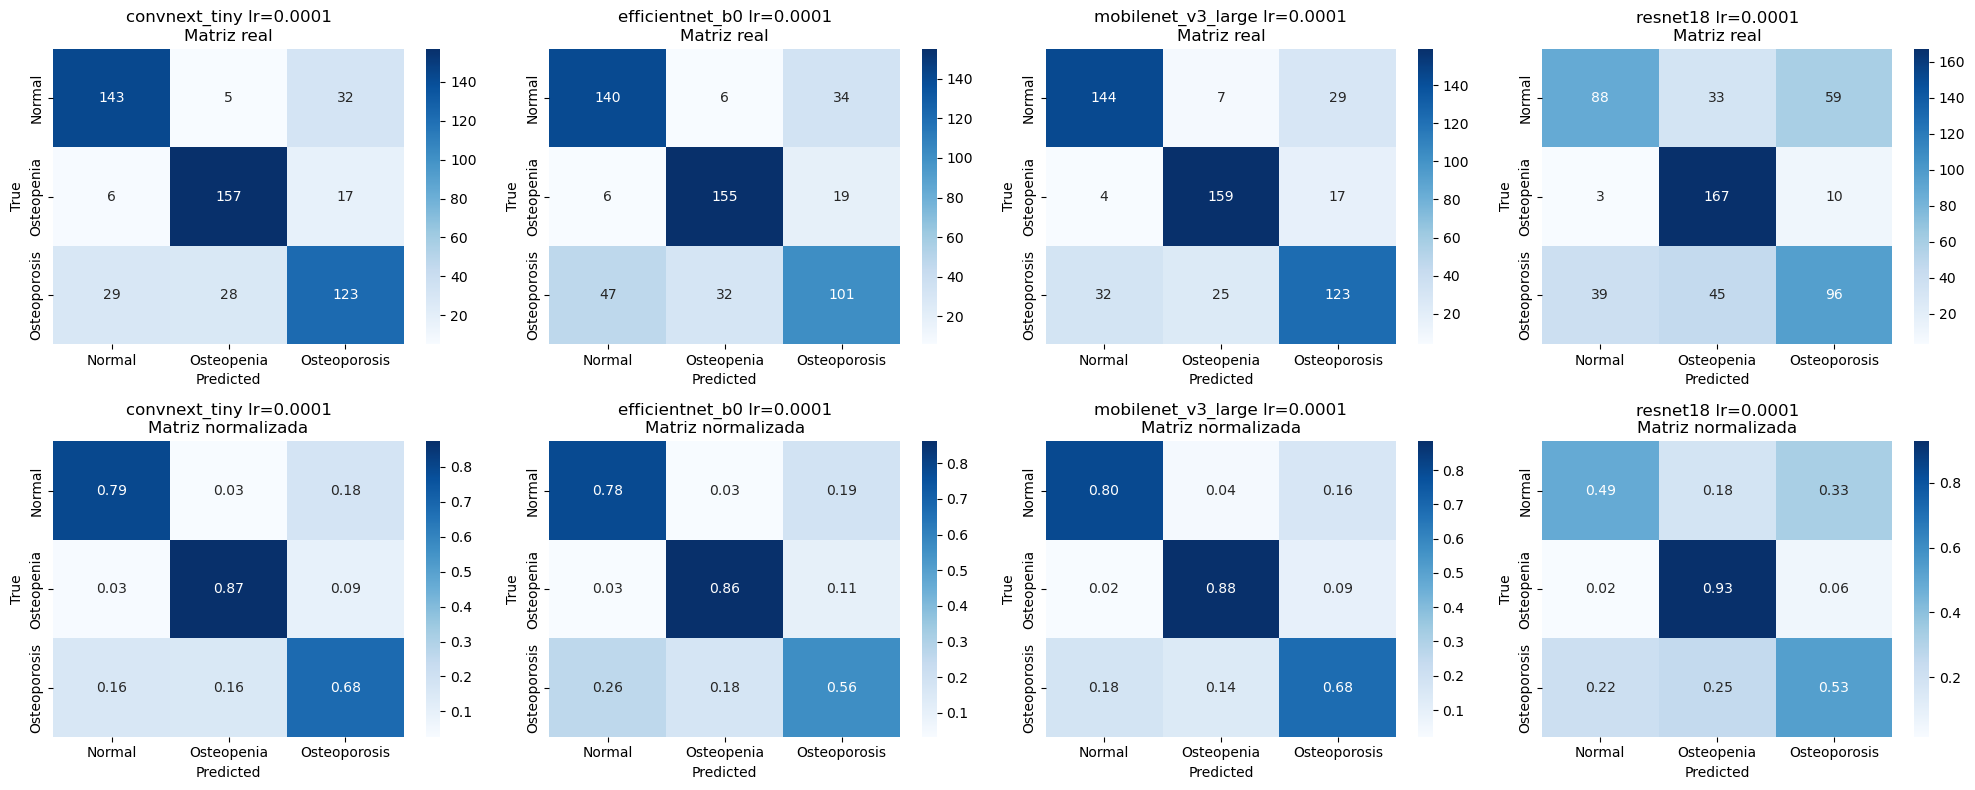

In [76]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

lr_target = 1e-4
model_names = sorted({k.split("_lr")[0] for k in results.keys()})

fig, axes = plt.subplots(2, len(model_names), figsize=(5 * len(model_names), 8))

for i, modelo in enumerate(model_names):
    key = f"{modelo}_lr{lr_target}"
    if key not in results:
        print(f"No hay resultados para {key}")
        continue

    y_true = results[key]["labels"].numpy()
    y_pred = results[key]["preds"].numpy()

    # Matriz real
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[0, i].set_title(f"{modelo} lr={lr_target}\nMatriz real")
    axes[0, i].set_xlabel("Predicted")
    axes[0, i].set_ylabel("True")

    # Matriz normalizada por fila
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=axes[1, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[1, i].set_title(f"{modelo} lr={lr_target}\nMatriz normalizada")
    axes[1, i].set_xlabel("Predicted")
    axes[1, i].set_ylabel("True")

plt.tight_layout()
plt.show()


## **8.4 Métricas adicionales**
---

- **Recall enfermo vs sano:** mide qué tan bien el modelo detecta a los pacientes enfermos (osteopenia u osteoporosis) sin confundirlos con sanos. No distingue entre tipos de enfermedad, solo sano vs enfermo.

- **F1 entre enfermedades:** evalúa el equilibrio entre precisión y recall al clasificar las distintas enfermedades, solo considerando pacientes enfermos. Esta métrica distingue entre osteopenia y osteoporosis.

- **Puntaje diagnóstico (Score Personalizado):** Evalua globalmente el desempeño clínico. Es un promedio ponderado de las métricas **recall** y **F1**. En este caso se asigna mayor peso al **recall** para reflejar mejor la capacidad del modelo de distinguir entre pacientes sanos y enfermos, mientras que la **F1** contribuye en menor medida para evaluar la diferenciación entre las dos patologías, que pueden tener distintos niveles de gravedad. Los pesos de este promedio ponderado pueden ajustarse según se considere necesario para enfatizar más o menos alguno de los aspectos.

In [77]:
from sklearn.metrics import recall_score, f1_score

# Defino las métricas

def compute_enfermo_vs_sano_recall(y_true, y_pred):
    # Convertir a binario: 0 = Normal, 1 = Enfermo (Osteopenia u Osteoporosis)
    y_true_bin = [0 if x == 0 else 1 for x in y_true]
    y_pred_bin = [0 if x == 0 else 1 for x in y_pred]
    return recall_score(y_true_bin, y_pred_bin)

def compute_enfermedades_f1(y_true, y_pred):
    # Filtro solo los casos enfermos
    y_true_sub = [x for x in y_true if x != 0]
    y_pred_sub = [p for x, p in zip(y_true, y_pred) if x != 0]
    return f1_score(y_true_sub, y_pred_sub, average='macro') 

def diagnostic_score(y_true, y_pred, alpha=0.7, beta=0.3):
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1_enf = compute_enfermedades_f1(y_true, y_pred)
    # Combino recall y f1 con pesos alpha y beta
    return alpha * recall + beta * f1_enf

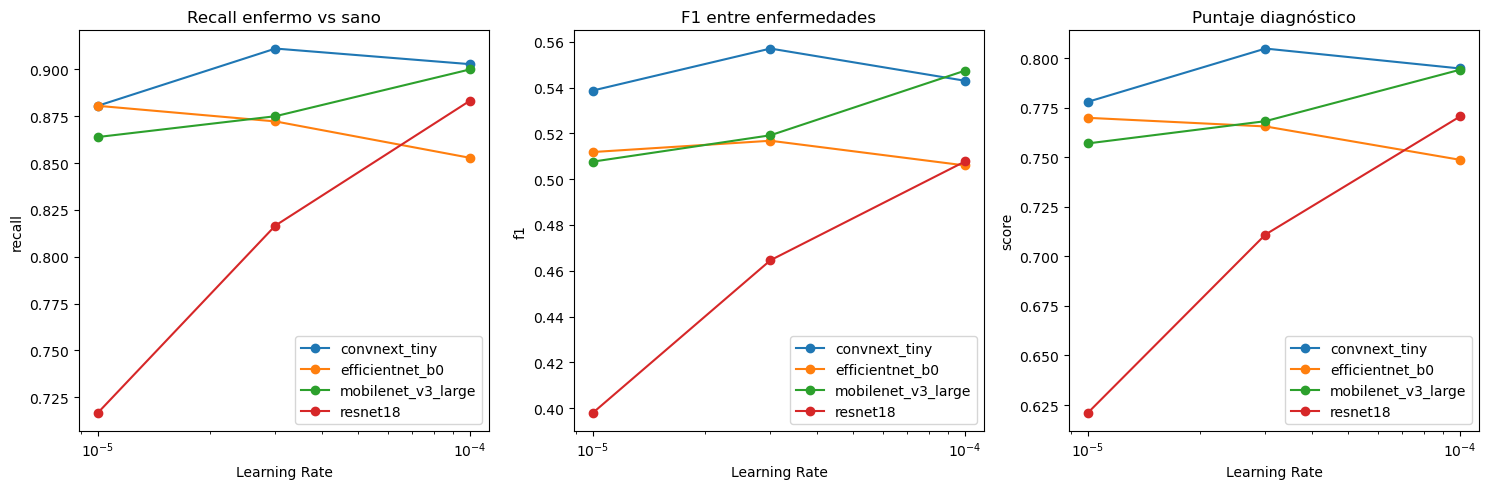

In [78]:
import pandas as pd

# Guardar métricas en lista
data = []
for key, vals in results.items():
    model_name, lr_str = key.split("_lr")
    lr = float(lr_str)
    
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    
    data.append({
        "modelo": model_name,
        "lr": lr,
        "recall": recall,
        "f1": f1,
        "score": score
    })

df = pd.DataFrame(data)
df = df.sort_values(by=["lr", "modelo"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

metricas = ["recall", "f1", "score"]
titulos = ["Recall enfermo vs sano", "F1 entre enfermedades", "Puntaje diagnóstico"]

for ax, metrica, titulo in zip(axes, metricas, titulos):
    for modelo, subdf in df.groupby("modelo"):
        ax.plot(subdf["lr"], subdf[metrica], marker="o", label=modelo)
    ax.set_title(titulo)
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel(metrica)
    ax.set_xscale("log")  
    ax.legend()

plt.tight_layout()
plt.show()


Basado en las métricas, los modelos que muestran un desempeño más consistente para las tres *learning rates* utilizadas son ConvNeXt Tiny, EfficientNet-B0 y MobileNet V3 Large. Por otro lado, ResNet18 presenta una mayor variabilidad en las métricas según la *learning rate* utilizada. Esto indica que este hiperparámetro tiene diferente sensibilidad según el modelo. Es importante realizar una búsqueda adecuada del mismo para asegurar que cada modelo alcance su mejor desempeño.

Sería conveniente analizar la performance de nuevos modelos, considerando los mismos *backbones* pero con más bloques/capas descongeladas. Además, teniendo en cuenta los resultados del paper mostrado en la introducción de esta notebook, se explora la utilización del modelo EfficientNet-B3, ya que presenta una mejora notable en la *accuracy* con un incremento relativamente pequeño en la cantidad total de parámetros entrenables, ofreciendo un buen *trade-off* entre desempeño y complejidad del modelo.

# **9. Nuevos Modelos**
---

En esta etapa se evalúan diferentes esquemas de descongelado para los modelos. El baseline corresponde a ResNet18 con la última capa del backbone (*fc*) descongelada. Además, se prueba una variante de ResNet18 con más capas o bloques descongeladas (a partir de layer3), EfficientNet-B0 y MobileNet V3 Large descongelando a partir de los dos últimos bloques, y EfficientNet-B3 descongelando únicamente el último bloque.  

Para esta comparación se seleccionó un *learning rate* de 1e-4 a modo de referencia, sin que implique que sea el más adecuado. Debería analizarse también el comportamiento con otros *learning rates*, ya que, como se mostró previamente, el desempeño del modelo al predecir depende fuertemente de este parámetro.


In [79]:
def train_and_test_new_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "fc"),
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "layer3"),
        (models.efficientnet_b3, models.EfficientNet_B3_Weights.DEFAULT, "features.7"),
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.6"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.7"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.6"),
    ]

    learning_rates = [1e-4]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            #name = fn.__name__
            name = f"{fn.__name__}_{freeze_name.replace('.', '_')}"
            print(f"Entrenando {name} con lr={lr}")
            #logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=40,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

In [80]:
new_results, new_history = train_and_test_new_models(train_loader, val_loader, test_loader)

torch.save(new_results, "new_results.pt")
torch.save(new_history, "new_history.pt")

Entrenando resnet18_fc con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 27/27 [00:10<00:00,  2.51it/s, v_num=0, val_loss=1.070, val_acc=0.385]

Metric val_loss improved. New best score: 1.075


Epoch 1: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s, v_num=0, val_loss=1.050, val_acc=0.468, train_loss=1.080]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 1.046


Epoch 4: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s, v_num=0, val_loss=0.998, val_acc=0.502, train_loss=0.951]

Metric val_loss improved by 0.048 >= min_delta = 0.001. New best score: 0.998


Epoch 5: 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, v_num=0, val_loss=0.977, val_acc=0.520, train_loss=0.910]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.977


Epoch 6: 100%|██████████| 27/27 [00:12<00:00,  2.23it/s, v_num=0, val_loss=0.964, val_acc=0.488, train_loss=0.900]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.964


Epoch 7: 100%|██████████| 27/27 [00:10<00:00,  2.54it/s, v_num=0, val_loss=0.960, val_acc=0.505, train_loss=0.887]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.960


Epoch 8: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s, v_num=0, val_loss=0.947, val_acc=0.523, train_loss=0.857]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.947


Epoch 9: 100%|██████████| 27/27 [00:09<00:00,  2.74it/s, v_num=0, val_loss=0.926, val_acc=0.542, train_loss=0.845]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.926


Epoch 12: 100%|██████████| 27/27 [00:09<00:00,  2.78it/s, v_num=0, val_loss=0.888, val_acc=0.553, train_loss=0.823]

Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 0.888


Epoch 17: 100%|██████████| 27/27 [00:09<00:00,  2.77it/s, v_num=0, val_loss=0.934, val_acc=0.487, train_loss=0.799]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.888. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 27/27 [00:09<00:00,  2.74it/s, v_num=0, val_loss=0.934, val_acc=0.487, train_loss=0.799]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True


Entrenando resnet18_layer3 con lr=0.0001


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
10.6 M    Trainable params
683 K     Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:10<00:00,  2.48it/s, v_num=0, val_loss=0.765, val_acc=0.696]

Metric val_loss improved. New best score: 0.765


Epoch 2: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=0.722, val_acc=0.698, train_loss=0.711]

Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.722


Epoch 4: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s, v_num=0, val_loss=0.644, val_acc=0.730, train_loss=0.645]

Metric val_loss improved by 0.078 >= min_delta = 0.001. New best score: 0.644


Epoch 5: 100%|██████████| 27/27 [00:11<00:00,  2.36it/s, v_num=0, val_loss=0.625, val_acc=0.755, train_loss=0.581]

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.625


Epoch 10: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s, v_num=0, val_loss=1.250, val_acc=0.586, train_loss=0.435]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.625. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 27/27 [00:11<00:00,  2.33it/s, v_num=0, val_loss=1.250, val_acc=0.586, train_loss=0.435]
Entrenando efficientnet_b3_features_7 con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.1 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.3 M     Trainable params
6.8 M     Non-trainable params
11.1 M    Total params
44.362    Total estimated model params size (MB)
8         Modules in train mode
531       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s, v_num=0, val_loss=0.862, val_acc=0.640]

Metric val_loss improved. New best score: 0.862


Epoch 1: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s, v_num=0, val_loss=0.854, val_acc=0.605, train_loss=0.917]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.854


Epoch 2: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s, v_num=0, val_loss=0.746, val_acc=0.700, train_loss=0.720]

Metric val_loss improved by 0.108 >= min_delta = 0.001. New best score: 0.746


Epoch 3: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s, v_num=0, val_loss=0.707, val_acc=0.701, train_loss=0.652]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.707


Epoch 5: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s, v_num=0, val_loss=0.625, val_acc=0.741, train_loss=0.535]

Metric val_loss improved by 0.082 >= min_delta = 0.001. New best score: 0.625


Epoch 10: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s, v_num=0, val_loss=0.732, val_acc=0.738, train_loss=0.366]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.625. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 27/27 [00:25<00:00,  1.08it/s, v_num=0, val_loss=0.732, val_acc=0.738, train_loss=0.366]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Entrenando mobilenet_v3_large_features_6 con lr=0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.2 M     Trainable params
40.1 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.753, val_acc=0.662]

Metric val_loss improved. New best score: 0.753


Epoch 2: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.693, val_acc=0.704, train_loss=0.706]

Metric val_loss improved by 0.060 >= min_delta = 0.001. New best score: 0.693


Epoch 5: 100%|██████████| 27/27 [00:15<00:00,  1.75it/s, v_num=0, val_loss=0.583, val_acc=0.792, train_loss=0.607]

Metric val_loss improved by 0.110 >= min_delta = 0.001. New best score: 0.583


Epoch 8: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.534, val_acc=0.772, train_loss=0.457]

Metric val_loss improved by 0.049 >= min_delta = 0.001. New best score: 0.534


Epoch 13: 100%|██████████| 27/27 [00:16<00:00,  1.63it/s, v_num=0, val_loss=0.868, val_acc=0.682, train_loss=0.594]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.534. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s, v_num=0, val_loss=0.868, val_acc=0.682, train_loss=0.594]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Entrenando efficientnet_b0_features_7 con lr=0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
1.5 M     Trainable params
2.9 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s, v_num=0, val_loss=0.954, val_acc=0.532]

Metric val_loss improved. New best score: 0.954


Epoch 1: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s, v_num=0, val_loss=0.823, val_acc=0.623, train_loss=0.944]

Metric val_loss improved by 0.131 >= min_delta = 0.001. New best score: 0.823


Epoch 2: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s, v_num=0, val_loss=0.758, val_acc=0.658, train_loss=0.765]

Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.758


Epoch 3: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s, v_num=0, val_loss=0.713, val_acc=0.701, train_loss=0.699]

Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.713


Epoch 6: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s, v_num=0, val_loss=0.667, val_acc=0.743, train_loss=0.636]

Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 0.667


Epoch 9: 100%|██████████| 27/27 [00:18<00:00,  1.42it/s, v_num=0, val_loss=0.648, val_acc=0.746, train_loss=0.570]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.648


Epoch 11: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s, v_num=0, val_loss=0.631, val_acc=0.765, train_loss=0.513]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.631


Epoch 12: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s, v_num=0, val_loss=0.608, val_acc=0.780, train_loss=0.506]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.608


Epoch 17: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s, v_num=0, val_loss=0.573, val_acc=0.788, train_loss=0.476]

Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 0.573


Epoch 22: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s, v_num=0, val_loss=0.687, val_acc=0.741, train_loss=0.416]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.573. Signaling Trainer to stop.


Epoch 22: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s, v_num=0, val_loss=0.687, val_acc=0.741, train_loss=0.416]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Entrenando efficientnet_b0_features_6 con lr=0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.5 M     Trainable params
851 K     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:15<00:00,  1.73it/s, v_num=0, val_loss=0.771, val_acc=0.667]

Metric val_loss improved. New best score: 0.771


Epoch 1: 100%|██████████| 27/27 [00:15<00:00,  1.76it/s, v_num=0, val_loss=0.674, val_acc=0.705, train_loss=0.869]

Metric val_loss improved by 0.097 >= min_delta = 0.001. New best score: 0.674


Epoch 4: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.670, val_acc=0.752, train_loss=0.631]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.670


Epoch 9: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.740, val_acc=0.792, train_loss=0.342]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.670. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 27/27 [00:15<00:00,  1.76it/s, v_num=0, val_loss=0.740, val_acc=0.792, train_loss=0.342]


In [81]:
new_results = torch.load("new_results.pt")
new_history = torch.load("new_history.pt")

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

A continuación se muestran las curvas de pérdida en entrenamiento (**Train Loss**), pérdida en validación (**Validation Loss**) y precisión en validación (**Validation Accuracy**) para los seis modelos presentados. Al igual que en los análisis anteriores, se utiliza *early stopping* para evitar que los modelos se sobreajusten durante el entrenamiento.

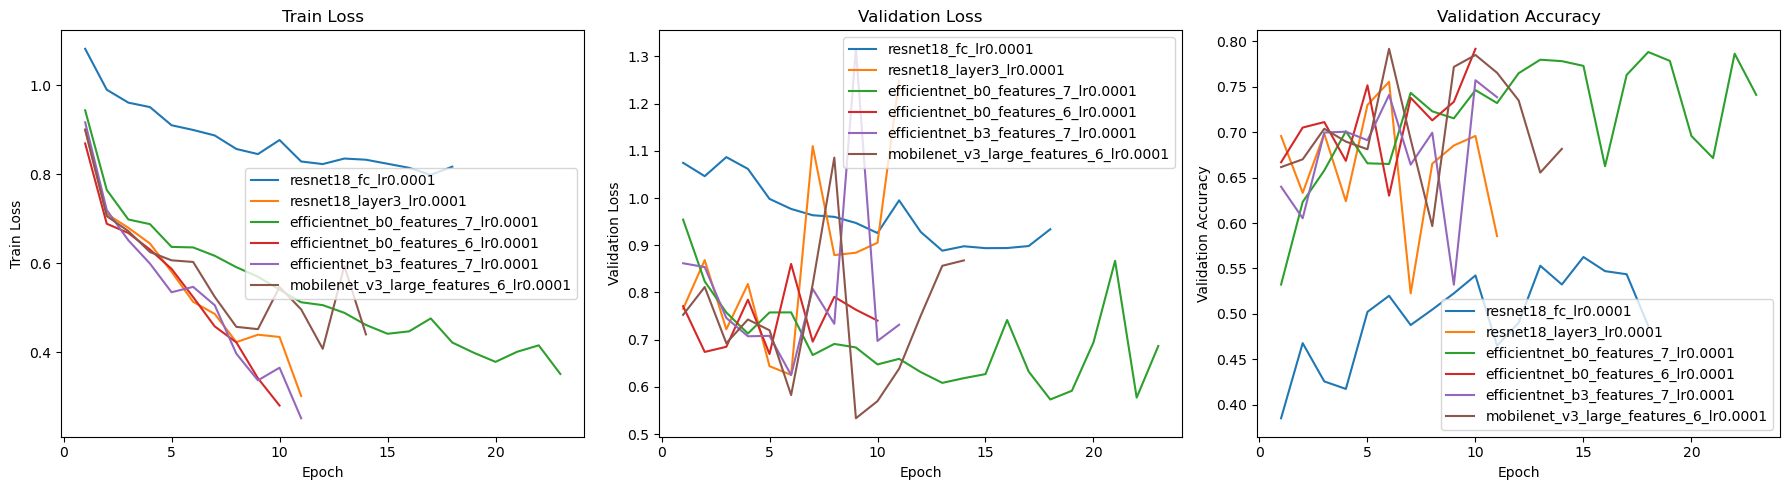

In [83]:

model_folders = [
    "resnet18_fc_lr0.0001",
    "resnet18_layer3_lr0.0001",
    "efficientnet_b0_features_7_lr0.0001",
    "efficientnet_b0_features_6_lr0.0001",
    "efficientnet_b3_features_7_lr0.0001",
    "mobilenet_v3_large_features_6_lr0.0001"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

history = load_history_from_logs()

for model in model_folders:
    if model not in history:
        print(f"No encontrado: {model}")
        continue
    df = history[model]
    epochs_train = df.dropna(subset=['train_loss'])['epoch'] + 1
    train_loss = df.dropna(subset=['train_loss'])['train_loss']
    val_df = df.dropna(subset=['val_loss', 'val_acc'])
    epochs_val = val_df['epoch'] + 1
    val_loss = val_df['val_loss']
    val_acc = val_df['val_acc']
    
    axes[0].plot(epochs_train, train_loss, label=model)
    axes[1].plot(epochs_val, val_loss, label=model)
    axes[2].plot(epochs_val, val_acc, label=model)

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")

axes[2].set_title("Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Validation Accuracy")

for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

Comparando las tres métricas utilizadas (**recall**, **F1** y el **score personalizado**) podemos observar lo siguiente:

En términos de desempeño, los mejores modelos son MobileNet V3 Large (mejor **recall** y mejor **score personalizado**) y EfficientNet-B3 (mejor **F1**). Seguidos a estos se encuentran los modelos ResNet18 con la última capa descongelada (*fc*), es decir, el baseline, y las dos versiones de EfficientNet-B0 (con distinto número de capas descongeladas). El peor desempeño se observa en ResNet18 con las capas descongeladas a partir de la *layer3* (10.625.539 parámetros entrenables).

El desempeño de los modelos, como se vio, puede depender en mayor o menor medida del *learning rate* elegido. Para ResNet18, al descongelar capas a partir de *layer3*, el rendimiento obtenido con el *learning rate* actual es inferior al logrado al descongelar únicamente la *fc*. Esto sugiere que, aunque al descongelar más capas se aumente significativamente el número de parámetros entrenables (10.625.539 vs 132.099), podría ser necesario ajustar el *learning rate* para que el modelo aproveche completamente su capacidad y alcance su máximo potencial.

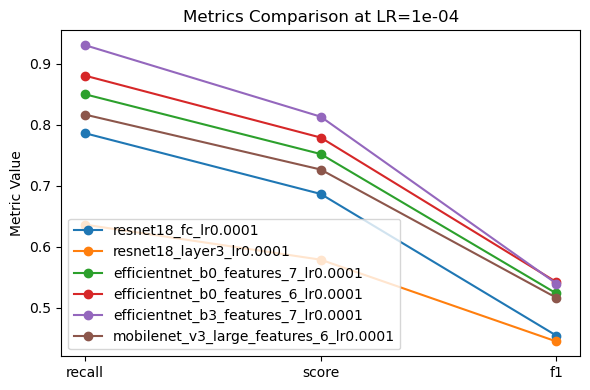

In [84]:
data = []

all_results = {**results, **new_results}

for key, vals in all_results.items():
    lr = float(key.split("_lr")[1])
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    data.append({"modelo": key, "lr": lr, "recall": recall, "f1": f1, "score": score})

df = pd.DataFrame(data)
df_lr = df[df["lr"] == 0.0001]

metrics = ["recall", "score", "f1"]
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(6,4))

for model in model_folders:
    subdf = df_lr[df_lr["modelo"].str.startswith(model.split("_lr")[0])]
    if subdf.empty:
        continue
    values = [subdf[metric].values[0] for metric in metrics]
    ax.plot(x, values, marker='o', label=model)

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Metric Value")
ax.set_title("Metrics Comparison at LR=1e-04")
ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [85]:
# MobileNet V3 Large
key_mobilenet = "mobilenet_v3_large_features_6_lr0.0001"
y_true = all_results[key_mobilenet]["labels"].numpy()
y_pred = all_results[key_mobilenet]["preds"].numpy()
score_mobilenet = diagnostic_score(y_true, y_pred)
print("Score personalizado MobileNet V3 Large: {:.3f}".format(score_mobilenet))

# ResNet18 baseline
key_resnet = "resnet18_lr3e-05"
y_true = all_results[key_resnet]["labels"].numpy()
y_pred = all_results[key_resnet]["preds"].numpy()
score_resnet = diagnostic_score(y_true, y_pred)
print("Score personalizado ResNet18 baseline: {:.3f}".format(score_resnet))


Score personalizado MobileNet V3 Large: 0.727
Score personalizado ResNet18 baseline: 0.711


In [86]:
def train_and_test_new_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.6"),
    ]

    learning_rates = [3e-5]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            #name = fn.__name__
            name = f"{fn.__name__}_{freeze_name.replace('.', '_')}"
            print(f"Entrenando {name} con lr={lr}")
            #logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=40,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

mn_results, mn_history = train_and_test_new_models(train_loader, val_loader, test_loader)

torch.save(mn_results, "mn_results.pt")
torch.save(mn_history, "mn_history.pt")

mn_results = torch.load("mn_results.pt")
mn_history = torch.load("mn_history.pt")

Entrenando mobilenet_v3_large_features_6 con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.2 M     Trainable params
40.1 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s, v_num=0, val_loss=1.050, val_acc=0.430]

Metric val_loss improved. New best score: 1.047


Epoch 1: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s, v_num=0, val_loss=0.903, val_acc=0.535, train_loss=1.030]

Metric val_loss improved by 0.144 >= min_delta = 0.001. New best score: 0.903


Epoch 2: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s, v_num=0, val_loss=0.866, val_acc=0.569, train_loss=0.863]

Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 0.866


Epoch 3: 100%|██████████| 27/27 [00:12<00:00,  2.15it/s, v_num=0, val_loss=0.783, val_acc=0.660, train_loss=0.744]

Metric val_loss improved by 0.083 >= min_delta = 0.001. New best score: 0.783


Epoch 5: 100%|██████████| 27/27 [00:13<00:00,  1.96it/s, v_num=0, val_loss=0.757, val_acc=0.686, train_loss=0.701]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.757


Epoch 7: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s, v_num=0, val_loss=0.697, val_acc=0.708, train_loss=0.612]

Metric val_loss improved by 0.060 >= min_delta = 0.001. New best score: 0.697


Epoch 9: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s, v_num=0, val_loss=0.668, val_acc=0.722, train_loss=0.598]

Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.668


Epoch 11: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s, v_num=0, val_loss=0.641, val_acc=0.718, train_loss=0.556]

Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.641


Epoch 16: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s, v_num=0, val_loss=0.932, val_acc=0.612, train_loss=0.446]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.641. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 27/27 [00:14<00:00,  1.89it/s, v_num=0, val_loss=0.932, val_acc=0.612, train_loss=0.446]


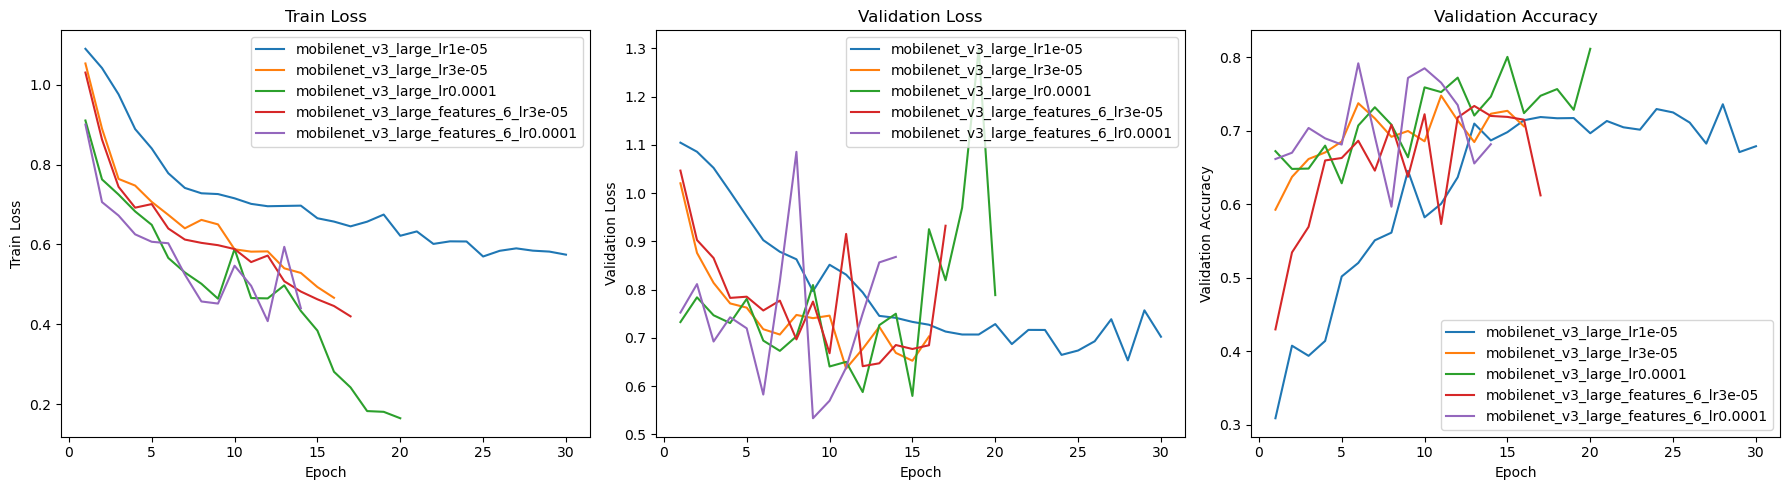

In [87]:
model_folders = [
    "mobilenet_v3_large_lr1e-05",
    "mobilenet_v3_large_lr3e-05",
    "mobilenet_v3_large_lr0.0001",
    "mobilenet_v3_large_features_6_lr3e-05",
    "mobilenet_v3_large_features_6_lr0.0001"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

history = load_history_from_logs()

for model in model_folders:
    if model not in history:
        print(f"No encontrado: {model}")
        continue
    df = history[model]
    epochs_train = df.dropna(subset=['train_loss'])['epoch'] + 1
    train_loss = df.dropna(subset=['train_loss'])['train_loss']
    val_df = df.dropna(subset=['val_loss', 'val_acc'])
    epochs_val = val_df['epoch'] + 1
    val_loss = val_df['val_loss']
    val_acc = val_df['val_acc']
    
    axes[0].plot(epochs_train, train_loss, label=model)
    axes[1].plot(epochs_val, val_loss, label=model)
    axes[2].plot(epochs_val, val_acc, label=model)

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")

axes[2].set_title("Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Validation Accuracy")

for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

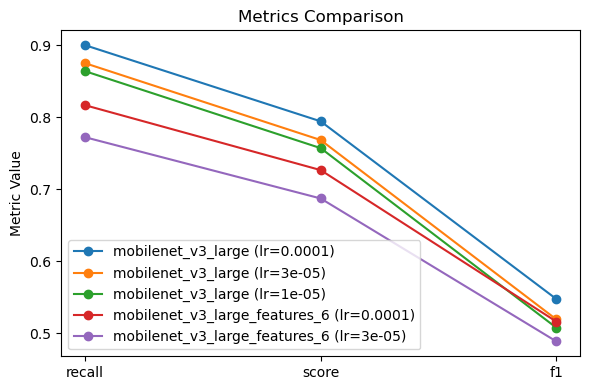

In [88]:
data = []

#all_results = {**results, **new_results, **mn_results, **mn_8_results}
all_results = {**results, **new_results, **mn_results}

for key, vals in all_results.items():
    if key not in model_folders:
        continue
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    data.append({"modelo": key, "recall": recall, "f1": f1, "score": score})

df = pd.DataFrame(data)
metrics = ["recall", "score", "f1"]
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(6,4))

for idx, row in df.iterrows():
    values = [row[metric] for metric in metrics]
    model_name = "_".join(row['modelo'].split("_lr")[:-1])
    lr = row['modelo'].split("_lr")[1]
    ax.plot(x, values, marker='o', label=f"{model_name} (lr={lr})")

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Metric Value")
ax.set_title("Metrics Comparison")
ax.legend(loc='best')

plt.tight_layout()
plt.show()


# **10. Conclusiones**
---

- Se partió del baseline **ResNet18** con la última capa descongelada, al que se añadió un modelo secuencial adicional después del backbone. Este bloque secuencial fue el mismo para todos los modelos utilizados.  
- Se probaron nuevos modelos descongelando distintos números de bloques, lo que permitió mejorar el desempeño del modelo baseline.  
- Para evaluar los modelos se utilizaron las métricas de **recall** y **F1**, considerando tanto la capacidad de distinguir entre pacientes sanos y enfermos como la diferenciación entre las dos patologías distintas.  
- Se definió un **score clínico personalizado** para comparar globalmente los modelos.  
- Se evaluaron distintos *learning rates* y se observó que el desempeño del modelo en la predicción es muy sensible a este hiperparámetro. Una selección apropiada del *learning rate* es fundamental para obtener predicciones aceptables, y su ajuste, junto con el número de bloques descongelados, resulta clave para mejorar el rendimiento del modelo.
- El mejor modelo evaluado fue **MobileNet V3 Large** con las bloques descongeladas a partir de *features.6* (3.178.611 parámetros entrenables). Con un *learning rate* de 1e-04, el **score personalizado** obtenido fue de **0.788**, superando al baseline **ResNet18** con la última capa descongelada (*fc*), que obtuvo un score de **0.738**.
